### The neural response at the fundamental frequency of speech is modulated by linguistic information

Code for reproducing the results presented in:

Kegler, M., Weissbart, H. & Reichenbach, T. (2021). "_The neural response at the fundamental frequency of speech is modulated by linguistic information_"

### Imports & helper functions

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.multitest import multipletests
import mne
from cmcrameri import cm
import seaborn as sns

def variance_inflation_factors(exog_df):
    """
    Compute variance inflation factor for columns in the dataframe.
    """
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

def plot_cc(ax, X, Y):
    """
    Helper function for generating scatterplots.
    """
    ax.scatter(X, Y, c='darkgrey', marker='o', edgecolor='k', s=8, lw=.2, alpha=.33, label='Words')

### Word-level features correlation analysis
Figure 1 - panel C

(5.5, 0.5)

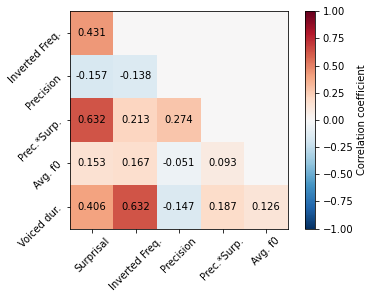

In [2]:
f = plt.figure()

### Load word-level features 
df_feats = pd.read_csv('./word-level_feats.csv', index_col=0)
del df_feats['reconstruction'] # Drop reconstruction scores

### Rename features to make the plot tidier
df_feats = df_feats.rename({'word_freq': 'Inverted Freq.', 
                            'surprisal': 'Surprisal', 
                            'precision': 'Precision', 
                            'precision_surp': 'Prec.*Surp.', 
                            'f0_mean': 'Avg. f0', 
                            'voiced': 'Voiced dur.'}, axis=1)

### Compute Pearson's correlation coef
ccs = np.corrcoef(df_feats.to_numpy().T)

### Remove the redundant half + diagonal
for i in range(ccs.shape[0]):
    for j in range(ccs.shape[1]):
        if i <= j:
            ccs[i,j] = 0

### Plot colormap
cmap = plt.imshow(ccs, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar(cmap, label='Correlation coefficient')

### Add text
for i in range(ccs.shape[0]):
    for j in range(ccs.shape[1]):
        if i > j:
            text = plt.text(j, i, ccs[i, j].round(3),
                       ha="center", va="center", color="k", fontsize=10)

### Clean up
plt.xticks(np.arange(len(df_feats.columns)), df_feats.columns, rotation=45)
plt.yticks(np.arange(len(df_feats.columns)), df_feats.columns, rotation=45)

plt.xlim(-.5, 4.5)
plt.ylim(5.5, .5)

### EEG linear model
Figure 3

Significant lags: [0.005 0.006 0.007 0.008 0.009 0.01  0.011 0.012 0.013 0.014 0.015 0.016
 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024 0.025 0.026] s


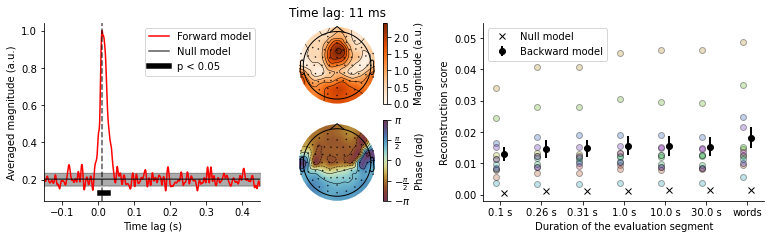

In [3]:
### Load forward model data & eeg info structure
fwd = np.load('./data/ForwardModel.npy')
fwd_null = np.load('./data/ForwardModel_null.npy')
times = np.arange(-0.25, 0.5, 0.001)
eeg_info = np.load('./data/eeg_info.npy', allow_pickle=True).item()

### Load backward model results
bkw = np.load('./data/BackwardModel.npy')
bkw_null = np.load('./data/BackwardModel_null.npy')
segments = ['0.1 s', '0.26 s', '0.31 s', '1.0 s', '10.0 s', '30.0 s', 'words']

fig = plt.figure(figsize=(10,3))

gs1 = fig.add_gridspec(2, 2, left=0, right=.3)
gs2 = fig.add_gridspec(2, 1, left=.3, right=.5)
gs3 = fig.add_gridspec(2, 2, left=.61, right=1)

ax = []

ax.append(fig.add_subplot(gs1[:, :]))
ax.append(fig.add_subplot(gs2[:1, :]))
ax.append(fig.add_subplot(gs2[1:, :]))
ax.append(fig.add_subplot(gs3[:, :]))

### Panel 1 - Forward model

n_perm = 100000 # Number of random permutations for bootstrapped significance

### Get magnitudes of forward model and its null counterpart
### - Step 1 average across participants
### - Step 2 compute absolute values
### - Step 3 average across channels
mags_TRF = np.abs(fwd.mean(0)).mean(-1)
mags_null = np.abs(fwd_null.mean(0)).mean(-1)

### Bootstrap null distribution from null model coefficients
mags_null_bs = np.random.choice(mags_null, 750*n_perm).reshape(750, n_perm)

### Compute empirical p-values
empirical_p = ((mags_TRF[:,np.newaxis] - mags_null_bs) < 0).sum(1)/n_perm

### Correct for multiple comparisons to get significant lags
signif_lags = multipletests(empirical_p, method='bonferroni')[0]
signif_plot = signif_lags.astype(np.float)
signif_plot[signif_plot == 0] = np.nan

### Plot panel 1
ax[0].plot(times, mags_TRF/max(mags_TRF), 'r', label='Forward model')
ax[0].plot(times, mags_null_bs.mean(-1)/max(mags_TRF), 'k', alpha=.66, label='Null model')
ax[0].fill_between(x=times,
                   y1=(mags_null_bs.mean(-1) + mags_null_bs.std(-1))/max(mags_TRF), 
                   y2=(mags_null_bs.mean(-1) - mags_null_bs.std(-1))/max(mags_TRF), color='k', alpha=.33)
ax[0].plot(times, signif_plot*.13, lw=5.5, c='k', label='p < 0.05')
ax[0].axvline(times[np.argmax(mags_TRF)], c='k', ls='--', alpha=.66)

### Tidy up the plot
ax[0].set_xlim(-0.150, 0.450)
ax[0].set_ylabel('Averaged magnitude (a.u.)')
ax[0].set_xlabel('Time lag (s)')
ax[0].legend(loc='best')

print('Significant lags: {} s'.format(times[signif_lags]))

### Panel 2 - magnitude at peak

topo_im, topo_cn = mne.viz.plot_topomap(np.abs(fwd.mean(0))[np.argmax(mags_TRF)]/max(mags_TRF), 
                                        eeg_info, axes=ax[1], 
                                        show=False, 
                                        cmap='Oranges')
ax[1].set_title('Time lag: {} ms'.format(np.int(times[np.argmax(mags_TRF)]*1000)))
cax = plt.colorbar(topo_im, ax=ax[1], label='Magnitude (a.u.)')
cax.set_ticks(np.arange(0., 2.6, .5))

### Panel 3 - phase at peak

topo_im, topo_cn = mne.viz.plot_topomap(np.angle(fwd.mean(0))[np.argmax(mags_TRF)], 
                                        eeg_info, axes=ax[2], 
                                        show=False, 
                                        cmap=cm.romaO, vmin=-np.pi, vmax=np.pi)

cax = plt.colorbar(topo_im, ax=ax[2], label='Phase (rad)')
cax.set_ticks(np.arange(-np.pi, np.pi + 0.000001, np.pi/2))
cax.set_ticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

### Panel 4 - Plot backward model

### Plot single-subject results (coloured)
c_sub = sns.color_palette('gist_rainbow', n_colors=6*13, desat=.5)[::6]

for i in range(bkw.shape[-1]):
    ax[-1].plot(bkw[:,i], alpha=.33, 
                marker='o', ls='', 
                c=c_sub[i], markeredgecolor='k')

### Plot grand avg. results
ax[-1].errorbar(np.arange(len(segments))+.2, bkw.mean(1), stats.sem(bkw, axis=1), 
                lw=2, c='k', marker='o', label='Backward model', zorder=100, ls='')

### Plot null models
ax[-1].plot(np.arange(len(segments))+.2, bkw_null.mean(1), 
            lw=2, c='k', marker='x', label='Null model', ls='')

### Tidy up plots
ax[-1].set_xticks(np.arange(7)+.1)
ax[-1].set_xticklabels(segments)
ax[-1].set_xlabel('Duration of the evaluation segment')
ax[-1].set_ylabel('Reconstruction score')
ax[-1].set_ylim(-0.002, 0.055)
ax[-1].legend()

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

### Multiple regression model
Table 1

In [4]:
### Load single-word features
df_lm = pd.read_csv('./word-level_feats.csv', index_col=0)

### Z-score all features
df_lm = df_lm.apply(stats.zscore, axis=0)

### Fit multiple regression model.
result = sm.rlm(formula="reconstruction ~ (f0_mean + voiced + word_freq + precision + surprisal + precision_surp)", data=df_lm).fit()

### Compute VIFs
VIFs = variance_inflation_factors(df_lm.drop('reconstruction', axis=1))
VIFs = VIFs.rename({'const':'Intercept'})

### Correct p-vlaues for multiple comparisons
fdr_p = multipletests(result.pvalues, method='fdr_by')[1]

### Add variables to model's summary
results_as_html = result.summary().tables[1].as_html()
summary_pd = pd.read_html(results_as_html, header=0, index_col=0)[0]
summary_pd['VIF'] = VIFs
summary_pd['p (FDR)'] = fdr_p
summary_pd['p < 0.05'] = fdr_p < 0.05
summary_pd

,coef,std err,z,P>|z|,[0.025,0.975],VIF,p (FDR),p < 0.05
Intercept,-0.0124,0.012,-1.051,0.293,-0.035,0.011,1.000000,7.600177e-01,False
f0_mean,-0.1091,0.012,-9.105,0.000,-0.133,-0.086,1.038153,1.572016e-18,True
voiced,0.0226,0.015,1.458,0.145,-0.008,0.053,1.735706,4.380688e-01,False
word_freq,-0.0404,0.016,-2.570,0.010,-0.071,-0.010,1.789664,3.695028e-02,True
precision,-0.0617,0.014,-4.513,0.000,-0.088,-0.035,1.350083,5.799215e-05,True
surprisal,-0.0721,0.018,-3.946,0.000,-0.108,-0.036,2.412501,3.601854e-04,True
precision_surp,0.0742,0.017,4.257,0.000,0.040,0.108,2.195162,1.251088e-04,True


### Single-word scatter plots
Figure 4

Note: This cell requirs the fitted model (the previous cell) to run.

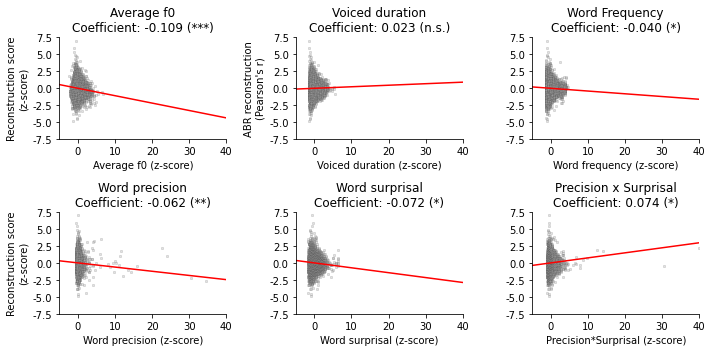

In [5]:
f, ax = plt.subplots(2,3, figsize=(10,5))

ax = ax.reshape(-1)

### Panel 1 - Avg. f0 vs reconstruction
plot_cc(ax[0], df_lm.f0_mean, df_lm.reconstruction)
ax[0].set_xlabel('Average f0 (z-score)')
ax[0].set_ylabel('Reconstruction score\n(z-score)')
ax[0].set_title('Average f0\nCoefficient: {:.3f} (***)'.format(summary_pd.loc['f0_mean', 'coef']))
ax[0].plot(np.arange(-100,100), np.arange(-100,100)*summary_pd.loc['f0_mean', 'coef'], c='r')

### Panel 2 - Voiced duration vs reconstruction
plot_cc(ax[1], df_lm.voiced, df_lm.reconstruction)
ax[1].set_xlabel('Voiced duration (z-score)')
ax[1].set_ylabel('ABR reconstruction\n(Pearson\'s r)')
ax[1].set_title('Voiced duration\nCoefficient: {:.3f} (n.s.)'.format(summary_pd.loc['voiced', 'coef']))
ax[1].plot(np.arange(-100,100), np.arange(-100,100)*summary_pd.loc['voiced', 'coef'], c='r')

### Panel 3 - Word frequency vs reconstruction
plot_cc(ax[2], df_lm.word_freq, df_lm.reconstruction)
ax[2].set_xlabel('Word frequency (z-score)')
ax[2].set_title('Word frequency vs ABR')
ax[2].set_title('Word Frequency\nCoefficient: {:.3f} (*)'.format(summary_pd.loc['word_freq', 'coef']))
ax[2].plot(np.arange(-100,100), np.arange(-100,100)*summary_pd.loc['word_freq', 'coef'], c='r')

### Panel 4 - Word precision vs reconstruction
plot_cc(ax[3], df_lm.precision, df_lm.reconstruction)
ax[3].set_xlabel('Word precision (z-score)')
ax[3].set_ylabel('Reconstruction score\n(z-score)')
ax[3].set_title('Word precision\nCoefficient: {:.3f} (**)'.format(summary_pd.loc['precision', 'coef']))
ax[3].plot(np.arange(-100,100), np.arange(-100,100)*summary_pd.loc['precision', 'coef'], c='r')

### Panel 5 - Word surprisal vs reconstruction
plot_cc(ax[4], df_lm.surprisal, df_lm.reconstruction)
ax[4].set_xlabel('Word surprisal (z-score)')
ax[4].set_title('Word surprisal\nCoefficient: {:.3f} (*)'.format(summary_pd.loc['surprisal', 'coef']))
ax[4].plot(np.arange(-100,100), np.arange(-100,100)*summary_pd.loc['surprisal', 'coef'], c='r')

### Panel 6 - Precision*Surprisal vs reconstruction
plot_cc(ax[5], df_lm.precision_surp, df_lm.reconstruction)
ax[5].set_xlabel('Precision*Surprisal (z-score)')
ax[5].set_title('Precision x Surprisal\nCoefficient: {:.3f} (*)'.format(summary_pd.loc['precision_surp', 'coef']))
ax[5].plot(np.arange(-100,100), np.arange(-100,100)*summary_pd.loc['precision_surp', 'coef'], c='r')

### Tidy up plots
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylim(-7.5, 7.5)
    a.set_yticks(np.arange(-7.5, 8, 2.5))
    a.set_yticklabels(np.arange(-7.5, 8, 2.5))
    a.set_xlim(-5, 40)

f.tight_layout()